In [96]:
import pandas as pd 

order = ['MSP', 'Energy', 'MaxLogit', 'Entropy', 'ReAct', 'Mahalanobis', 'ViM', 'Ensemble', 'Logic', 'Logic+', 'LogicOOD', 'LogicOOD+']

result_df = pd.read_csv("results.csv")
del result_df["Unnamed: 0"]

print((result_df.groupby(by=["Method", "Seed"]).mean() * 100).groupby("Method").agg(["mean", "sem"]).reindex(order).to_latex(float_format="%.2f").replace("& 0.", "& $\pm$ 0.").replace("& 2.", "& $\pm$ 2."))



\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95TPR} \\
{} &  mean &  sem &    mean &  sem &     mean &  sem &     mean &  sem \\
Method      &       &      &         &      &          &      &          &      \\
\midrule
MSP         & 94.79 & $\pm$ 0.12 &   99.14 & $\pm$ 0.03 &    78.01 & $\pm$ 0.44 &    21.99 & $\pm$ 0.49 \\
Energy      & 97.38 & $\pm$ 0.09 &   99.61 & $\pm$ 0.01 &    84.69 & $\pm$ 0.44 &    12.02 & $\pm$ 0.48 \\
MaxLogit    & 97.09 & $\pm$ 0.09 &   99.55 & $\pm$ 0.02 &    84.29 & $\pm$ 0.43 &    12.54 & $\pm$ 0.42 \\
Entropy     & 96.41 & $\pm$ 0.10 &   99.45 & $\pm$ 0.02 &    81.11 & $\pm$ 0.45 &    16.51 & $\pm$ 0.51 \\
ReAct       & 98.83 & $\pm$ 0.05 &   99.84 & $\pm$ 0.01 &    92.68 & $\pm$ 0.20 &     5.67 & $\pm$ 0.23 \\
Mahalanobis & 98.17 & $\pm$ 0.04 &   99.77 & $\pm$ 0.01 &    91.86 & $\pm$ 0.15 &     7.59 & $\pm$ 0.16 \\
ViM         & 99.59 & $\pm$ 0.

In [97]:
import torch 


cache = torch.load("../data/models/resnet/cache.pt", map_location="cpu")

print(list(cache.dataset_all_logits.keys()))

['FoolingImages', 'Textures', 'ImageNetO', 'ImageNetR', 'ImageNetA', 'NINCO', 'iNaturalist']


In [98]:
from pytorch_ood.detector import MaxSoftmax

def _get_detector_score(x):
    n_samples = x[0].shape[0]

    # calc ensemble scores
    scores = torch.zeros(size=(n_samples,))

    for feature in x:
        scores += MaxSoftmax.score(feature)

    return scores / len(x)

In [99]:
from detectors import PrimateNetLogicDetector
from pytorch_ood.utils import is_known
import seaborn as sb 
import matplotlib.pyplot as plt 

sb.set(style="white", font_scale=1.2)

 


<ipython-input-100-e3dccc535686>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "IN (Missclassified)"


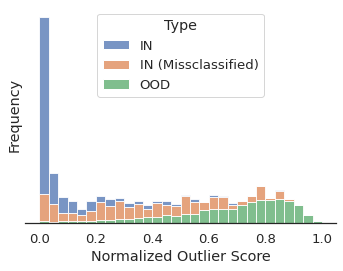

In [100]:
from pytorch_ood.detector import MaxSoftmax 
from sklearn.preprocessing import MinMaxScaler

logits = cache.dataset_all_logits["NINCO"]
oe_logits = cache.dataset_oe_logits["NINCO"]
ys = cache.dataset_labels["NINCO"][0].cpu()

y_hat = logits[0].argmax(dim=1)

scores = MaxSoftmax.score(logits[0]).numpy()

scaler = MinMaxScaler().fit(scores.reshape(-1, 1))
scores = scaler.transform(scores.reshape(-1, 1)).reshape(-1)

# df = pd.DataFrame({"Scores": scores, "label": ys})
# df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")
df = pd.DataFrame({"Scores": scores, "label": ys, "predicted": y_hat})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")
df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "IN (Missclassified)"

fig, ax = plt.subplots(figsize=(5,4))

# ,
sb.histplot(data=df, x="Scores", hue="Type", multiple="stack", stat="density", common_norm=False, bins=30)
# sb.kdeplot(data=df, x="Scores", common_norm=False, fill=True, hue="Type", palette="crest", bw_method=0.1, clip=[0,1]) # , palette="crest" # , ,
sb.move_legend(ax, "upper center")
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True, bottom=False)
plt.ylabel("Frequency")
plt.xlim([-0.05,1.05])
plt.yticks([])
plt.tight_layout()

plt.savefig("/home/ki/primatenet-msp.pdf", bbox_inches="tight")

<ipython-input-101-22dc7e6d7706>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "IN (Missclassified)"


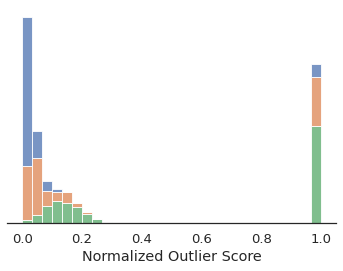

In [101]:

detector = PrimateNetLogicDetector(models=[], oe_model=None)

logits = cache.dataset_all_logits["NINCO"]
oe_logits = cache.dataset_oe_logits["NINCO"]
ys = cache.dataset_labels["NINCO"][0].cpu()

scores = _get_detector_score(logits)
# scores += scores.min()
# scores /= scores.max()

y_hat, world_models = detector._get_world_models(logits)
consistent = detector._check_consistency(y_hat, world_models)

# oe_consistent = oe_logits.argmax(dim=1).long() # assuming positive class is one 
consistent = consistent # & oe_consistent.cpu()
        
total = scores * consistent + 1 

df = pd.DataFrame({"Scores": total.numpy(), "label": ys, "predicted": y_hat})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")
df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "IN (Missclassified)"

# df = pd.DataFrame({"Scores": total.numpy(), "label": ys})
# df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")

fig, ax = plt.subplots(figsize=(5,4))

# ,
sb.histplot(data=df, x="Scores", hue="Type", multiple="stack", stat="density", common_norm=False, bins=30,  legend=False)
# sb.kdeplot(data=df, x="Scores", common_norm=False, fill=True, hue="Type", palette="crest", bw_method=0.1, clip=[0,1], legend=False) # , palette="crest" # , ,
plt.ylabel("")
# sb.move_legend(ax, "upper right")
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True, bottom=False)
plt.xlim([-0.05,1.05])
plt.yticks([])
plt.tight_layout()


plt.savefig("/home/ki/primatenet-logic.pdf", bbox_inches="tight")

<ipython-input-102-7c3a8ddbaa84>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "IN (Missclassified)"


18.625
46.83544158935547


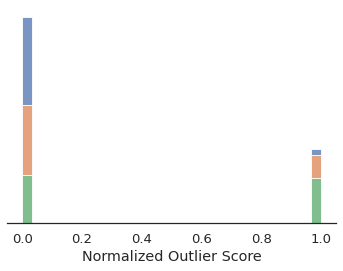

In [102]:
from importlib import reload
import detectors
reload(detectors)

from detectors import PrimateNetLogicOnlyDetector

detector = PrimateNetLogicOnlyDetector(models=[], oe_model=None)

logits = cache.dataset_all_logits["NINCO"]
oe_logits = cache.dataset_oe_logits["NINCO"]
ys = cache.dataset_labels["NINCO"][0].cpu()

consistent = detector._check_consistency(y_hat, world_models)
total = (1-consistent).float()

# df = pd.DataFrame({"Scores": total.numpy(), "label": ys})
# df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")
df = pd.DataFrame({"Scores": total.numpy(), "label": ys, "predicted": y_hat})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")
df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "IN (Missclassified)"

fig, ax = plt.subplots(figsize=(5,4))

# ,
sb.histplot(data=df, x="Scores", hue="Type", multiple="stack", stat="density", common_norm=False, bins=30,  legend=False)
# sb.histplot(data=df, x="Scores", hue="Type", multiple="stack", stat="density", common_norm=False, bins=30)
# sb.kdeplot(data=df, x="Scores", common_norm=False, fill=True, hue="Type", palette="crest", bw_method=0.1, clip=[0,1], legend=False) # , palette="crest" # , ,
plt.ylabel("")
# sb.move_legend(ax, "upper right")
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True, bottom=False)
plt.xlim([-0.05,1.05])
plt.yticks([])
plt.tight_layout()

plt.savefig("/home/ki/primatenet-logic-only.pdf", bbox_inches="tight")

ys = cache.dataset_labels["NINCO"][0].cpu()
print(100 - ((ys[is_known(ys)] == y_hat[is_known(ys)]).float().mean() * 100).item())



ys = cache.dataset_labels["NINCO"][0].cpu()
print(100 - ((ys[is_known(ys) & (total > 0.5)] == y_hat[is_known(ys) & (total > 0.5)]).float().mean() * 100).item())

<ipython-input-103-7abdfb31cb8e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "IN (Missclassified)"


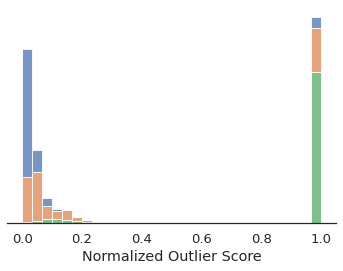

In [103]:

detector = PrimateNetLogicDetector(models=[], oe_model=None)

logits = cache.dataset_all_logits["NINCO"]
oe_logits = cache.dataset_oe_logits["NINCO"]
ys = cache.dataset_labels["NINCO"][0].cpu()

scores = _get_detector_score(logits)
# scores += scores.min()
# scores /= scores.max()
y_hat, world_models = detector._get_world_models(logits)
consistent = detector._check_consistency(y_hat, world_models)

oe_consistent = oe_logits.argmax(dim=1).long() # assuming positive class is one
consistent = consistent & oe_consistent.cpu()

total = scores * consistent + 1

df = pd.DataFrame({"Scores": total.numpy(), "label": ys, "predicted": y_hat})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")
df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "IN (Missclassified)"
#
# df = pd.DataFrame({"Scores": total.numpy(), "label": ys})
# df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")

fig, ax = plt.subplots(figsize=(5,4))

# ,

sb.histplot(data=df, x="Scores", hue="Type", multiple="stack", stat="density", common_norm=False, bins=30,  legend=False)

# sb.kdeplot(data=df, x="Scores", common_norm=False, fill=True, hue="Type", palette="crest", bw_method=0.1, clip=[0,1], legend=False) # , palette="crest" # , ,
plt.ylabel("")
# sb.move_legend(ax, "upper right")
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True, bottom=False)
plt.xlim([-0.05,1.05])
plt.yticks([])
plt.tight_layout()


plt.savefig("/home/ki/primatenet-logic-oe.pdf", bbox_inches="tight")

<ipython-input-104-c0db7e5de051>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "IN (Missclassified)"


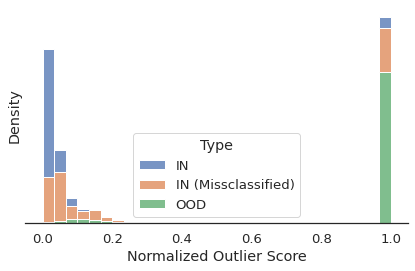

In [104]:
sb.set_style("white")

df = pd.DataFrame({"Scores": total.numpy(), "label": ys, "predicted": y_hat})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")
df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "IN (Missclassified)"
# df["Type"][(~is_known(ys)).numpy()] = "OOD"


fig, ax = plt.subplots(figsize=(6,4))

# , 
sb.histplot(data=df, x="Scores", hue="Type", multiple="stack", stat="density", common_norm=False, bins=30) # , palette="crest" # , ,
# common_norm=False, fill=True, hue="Type", bw_method=0.2, clip=[0,1]
# sb.move_legend(ax, "upper left")
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True, bottom=False)
plt.xlim([-0.05,1.05])
plt.yticks([])
plt.tight_layout()

plt.savefig("/home/ki/abc.pdf", bbox_inches="tight")


<ipython-input-105-b4ef6bd357c9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "Wrong"


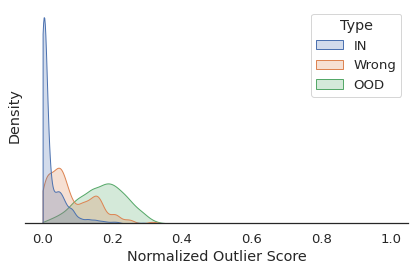

In [105]:
sb.set_style("white")

df = pd.DataFrame({"Scores": scores + 1, "label": ys, "predicted": y_hat})
df["Type"] = df["label"].apply(lambda x: "IN" if is_known(x) else "OOD")

df["Type"][(is_known(ys) & (y_hat != ys)).numpy()] = "Wrong"
# df["Type"][(~is_known(ys)).numpy()] = "OOD"


fig, ax = plt.subplots(figsize=(6,4))

# , 
sb.kdeplot(data=df, x="Scores", common_norm=False, fill=True, hue="Type", bw_method=0.2, clip=[0,1]) # , palette="crest" # , ,
sb.move_legend(ax, "upper right")
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel("Normalized Outlier Score")
sb.despine(left=True, right=True, top=True, bottom=False)
plt.xlim([-0.05,1.05])
plt.yticks([])
plt.tight_layout()


In [106]:
# plt.hist(total.numpy())

In [107]:
consistent

tensor([1, 1, 1,  ..., 0, 0, 0])

In [108]:
from pytorch_ood.utils import OODMetrics

# m = OODMetrics()
# m.update(-consistent.float(), ys)
# m.compute()

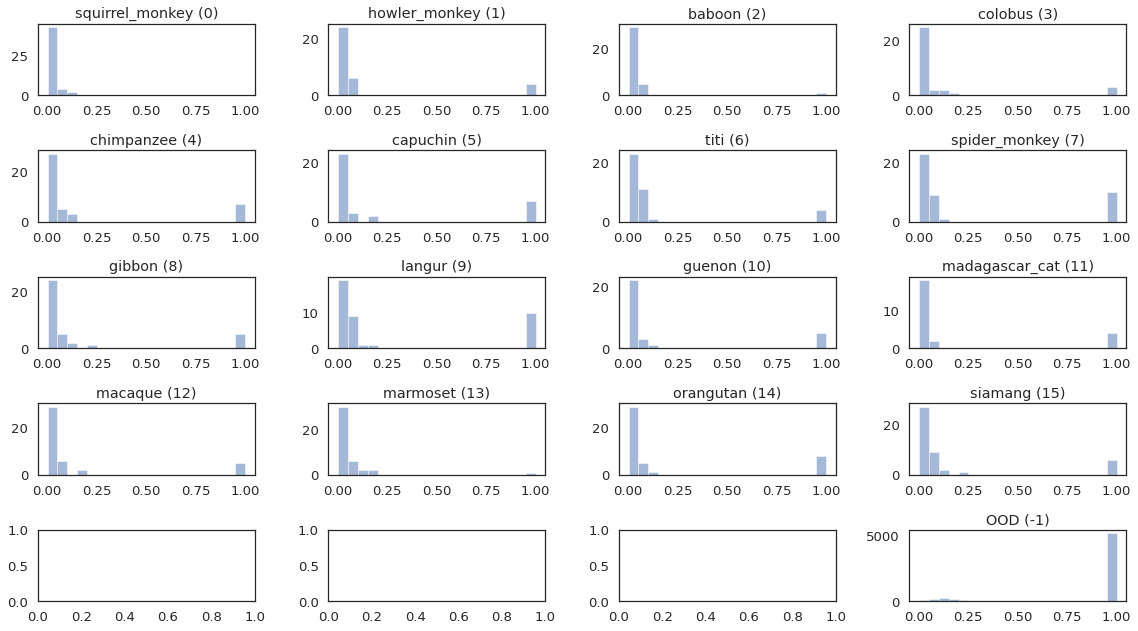

In [110]:
from primatenet import PrimateNet

class_idx_to_name = {i[1]: i[0] for i in PrimateNet.data.values()}
# class_idx_to_name.update({-1: "OOD"})

fig, axs = plt.subplots(5,4, figsize=(16,9))

axs = axs.flatten()

bins = 20 

known = ys >= 0 

for clazz in ys.unique():
    idx = ys == clazz
    
    _, bins, _ = axs[clazz].hist(total[idx].numpy(), alpha=0.5, bins=bins) # , range=[0, 1]
    name = class_idx_to_name[clazz.item()] if clazz.item() in class_idx_to_name else "OOD"
    axs[clazz].set_title(f"{name} ({clazz.item()})")
    
    # plt.title(str(clazz))
plt.tight_layout()
plt.show()


In [111]:
import torch 



In [112]:
# from pytorch_ood.utils import is_known
#
# res = []
#
# for i in range(10):
#     cache = torch.load(f"../data/models/{i}/cache.pt", map_location="cpu")
#     logits = cache.dataset_all_logits["ImageNetO"][0]
#     ys = cache.dataset_labels["ImageNetO"][0]
#
#     known = is_known(ys)
#
#     err = 1 - (logits[known].argmax(dim=1) == ys[known]).long().sum() / known.long().sum()
#     res.append(err)

In [113]:
# import numpy as np
#
# np.array(res)